#### Set up Google Colab and Fastai

In [1]:
# Google Colab init setup
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
Done.


In [0]:
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /content/colab_util_repo
!mv /content/colab_util_repo/colab_util.py colab_util.py 
!rm -r /content/colab_util_repo
!pip install pydrive

In [0]:
# Transfer zipped csv from Drive to Colab env
from colab_util import *
drive_handler = GoogleDriveHandler()
import glob

drive_handler.download('data/train_data.zip', 
                       target_path='colab_archive/donkey_car/train_data.zip')

In [0]:
# Unzip csv files
!unzip data/train_data.zip

In [7]:
!pwd

/content


#### Set up Data

In [0]:
from fastai.vision import *
path = Path('/content')

In [0]:
# no random flip, random brightness adjust, random zoom in
tfms = get_transforms(do_flip = False,
                                flip_vert = False,
                                max_lighting = 0.2,
                                max_zoom = 1.1)

In [0]:
data = (ImageItemList.from_csv(path, 'driving_log_new.csv', folder = 'IMG_NEW')
            .random_split_by_pct()
            .label_from_df()
            .transform(tfms, size = 224)
            .databunch())

#### View Data

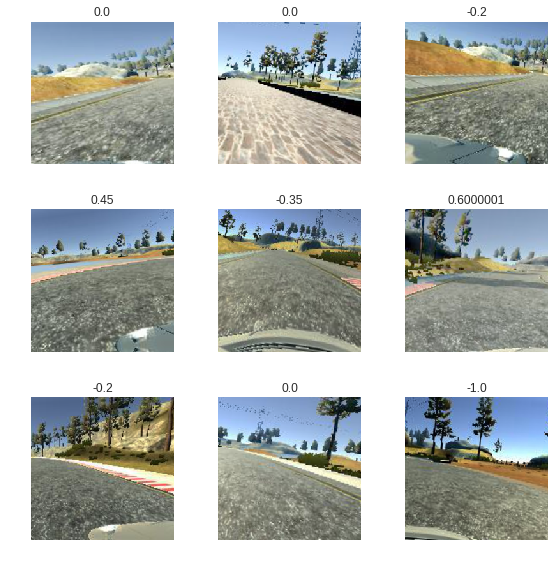

In [11]:
# view samples
data.show_batch(rows=3, figsize=(8, 8))

In [12]:
len(data.train_ds), len(data.valid_ds)

(2643, 660)

#### Learning Rate Finder

In [0]:
# deploy pretrained resnet34
# using mean square error as metrics
learn = create_cnn(data, models.resnet34, metrics = mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


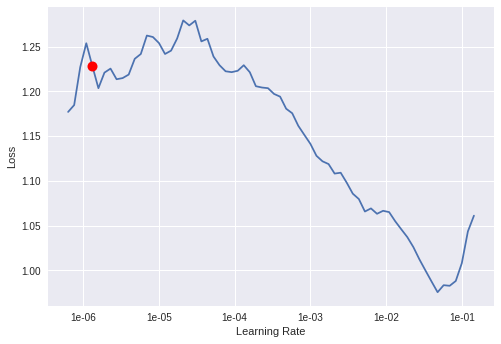

In [16]:
# 1e-3 to 1e-2 is used as it yields a big rate of decrease
learn.lr_find()
learn.recorder.plot();

#### Train Last Layer with Precomputing

In [17]:
# train a cycle of 4 epochs with cosine annealing
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,mean_squared_error
1,0.773542,0.229563,0.229563
2,0.387445,0.161383,0.161383
3,0.254645,0.128853,0.128853
4,0.195863,0.115848,0.115848


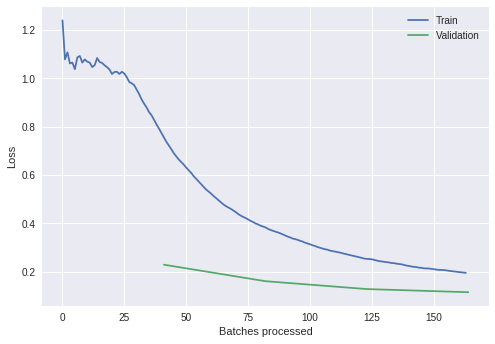

In [22]:
learn.recorder.plot_losses()

In [23]:
# train one more cycle
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,mean_squared_error
1,0.145806,0.130268,0.130268
2,0.165327,0.136202,0.136202
3,0.148464,0.099039,0.099039
4,0.126725,0.090239,0.090239


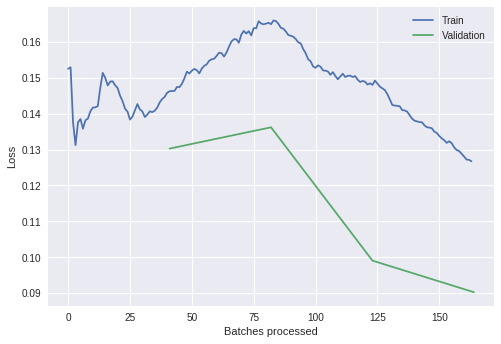

In [24]:
learn.recorder.plot_losses()

In [0]:
# checkpoint
learn.save('model_resnet34_stage1')

#### Train for All Layers with Data Augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05


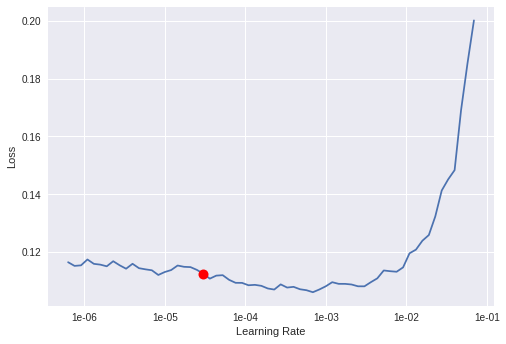

In [25]:
# unfreeze layers above
learn.unfreeze()
# find suitable learning rate again
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,mean_squared_error
1,0.106495,0.087798,0.087798
2,0.096657,0.076502,0.076502
3,0.086127,0.070444,0.070444
4,0.078299,0.066470,0.066470
5,0.075687,0.065400,0.065400


In [31]:
learn.fit_one_cycle(6, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,mean_squared_error
1,0.068928,0.069704,0.069704
2,0.071959,0.067149,0.067149
3,0.069421,0.072863,0.072863
4,0.066445,0.064946,0.064946
5,0.061876,0.060618,0.060618
6,0.058210,0.060014,0.060014


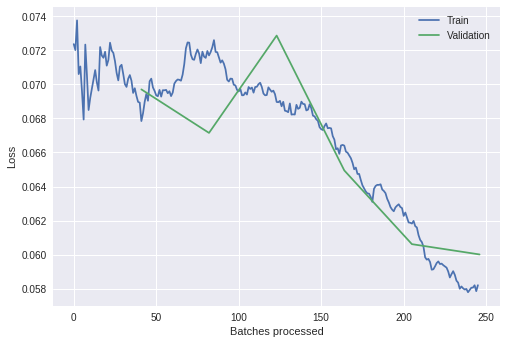

In [32]:
learn.recorder.plot_losses()

In [0]:
learn.save('model_resnet34_stage2')

In [34]:
learn.fit_one_cycle(10, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,mean_squared_error
1,0.055043,0.061358,0.061358
2,0.056483,0.059456,0.059456
3,0.061042,0.071352,0.071352
4,0.059671,0.070170,0.070170
5,0.058352,0.062780,0.062780
6,0.054907,0.061917,0.061917
7,0.049962,0.061117,0.061117
8,0.044584,0.058878,0.058878
9,0.040180,0.054345,0.054345
10,0.038193,0.054611,0.054611


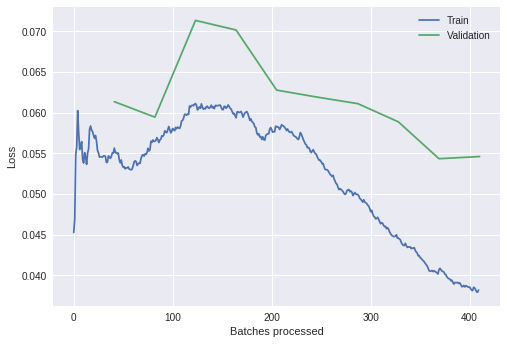

In [35]:
learn.recorder.plot_losses()

In [0]:
learn.save('model_resnet34_stage2')

In [58]:
learn.fit_one_cycle(20, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,mean_squared_error
1,0.034524,0.056454,0.056454
2,0.035904,0.054532,0.054532
3,0.035593,0.057343,0.057343
4,0.038092,0.055234,0.055234
5,0.039083,0.058015,0.058015
6,0.040789,0.062787,0.062787
7,0.040545,0.060193,0.060193
8,0.039435,0.053080,0.053080
9,0.036519,0.057514,0.057514
10,0.034404,0.058227,0.058227


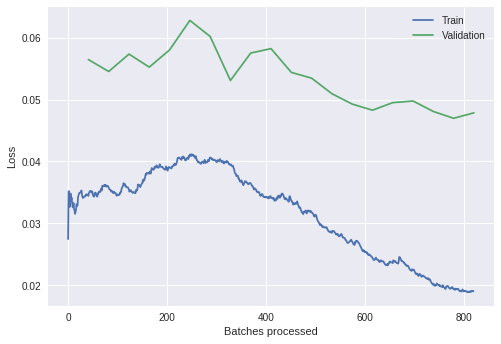

In [59]:
learn.recorder.plot_losses()

In [0]:
learn.save('model_resnet34_stage2')

#### Test Time Augmentation (Ensembling Prediction)

In [62]:
# currently can't run
log_preds,y = learn.TTA()

#### Result Analysis

In [47]:
# currently can't get top losses
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

#### Upload Model to Google Drive

In [53]:
!ls models

model_resnet34_stage1.pth  resnet34-333f7ec4.pth
model_resnet34_stage2.pth  tmp.pth


In [67]:
# From Colab VM to Drive (from /tmp in Colab VM)
from colab_util import *
drive_handler = GoogleDriveHandler()
import glob
archived_files = ['/content/models/model_resnet34_stage2.pth']

# Archived to /tmp folder
tar_file_path = create_archive('model_resnet34_stage2', local_file_paths=archived_files, verbose=True)
tar_file_path

ignore the common prefix /content/models/
running shell command: 
tar -czvf /tmp/model_resnet34_stage2.tar.gz -C /content/models/ model_resnet34_stage2.pth
model_resnet34_stage2.pth



'/tmp/model_resnet34_stage2.tar.gz'

In [68]:
drive_handler.upload(tar_file_path, parent_path='colab_archive/donkey_car')

'1esB2QchJ5g3TmbSdgf4y2PpplU3Cwo7l'